## Nonlinear Schrödinger Equation

The nonlinear Schrödinger equation with periodic boundary conditions is given by:

$$
i h_t + 0.5 h_{xx} + |h|^2 h = 0, \quad x \in [-5, 5], \quad t \in [0, \pi/2].
$$

### Initial and Boundary Conditions

- **Initial Condition**:
  $$
  h(0, x) = 2 \, \text{sech}(x).
  $$

- **Periodic Boundary Conditions**:
  $$
  h(t, -5) = h(t, 5), \quad h_x(t, -5) = h_x(t, 5).
  $$


## Loss Function

The total loss is defined as:

$$
MSE = MSE_0 + MSE_b + MSE_f,
$$

where:

- **Initial Data Loss**:
  $$
  MSE_0 = \frac{1}{N_0} \sum_{i=1}^{N_0} \left| h(0, x_i^0) - h_i^0 \right|^2,
  $$

- **Boundary Condition Loss**:
  $$
  MSE_b = \frac{1}{N_b} \sum_{i=1}^{N_b} \left( \left| h(t_b^i, -5) - h(t_b^i, 5) \right|^2 + \left| h_x(t_b^i, -5) - h_x(t_b^i, 5) \right|^2 \right),
  $$

- **PDE Residual Loss**:
  $$
  MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} \left| f(t_f^i, x_f^i) \right|^2,
  $$

with:
$$
f(t, x) = i h_t + 0.5 h_{xx} + |h|^2 h.
$$


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pyDOE import lhs
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda:3")


In [5]:
samples_center = lhs(2, samples=10, criterion="center")
samples_center # 0~1


array([[0.05, 0.65],
       [0.25, 0.55],
       [0.85, 0.15],
       [0.45, 0.25],
       [0.65, 0.45],
       [0.35, 0.95],
       [0.95, 0.05],
       [0.75, 0.75],
       [0.15, 0.85],
       [0.55, 0.35]])

In [6]:
class model(nn.Module) :
    def __init__(self, hidden_dims) :
        super(model, self).__init__()

        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.layers = nn.ModuleList(self.layers)

        for layer in self.layers :
            nn.init.xavier_uniform_(layer.weight)

        self.act = nn.Tanh()

    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

In [7]:
def derivative(y, t) :
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

In [8]:
# LHS를 사용하여 시간(t)과 공간(x)에서 샘플링
lhs_samples = lhs(2, samples= 2000)  # 2차원 샘플링 (시간, 공간)
t_samples = lhs_samples[:, 0] * (np.pi/2)
x_samples = lhs_samples[:, 1] * 10 - 5      # [-5, 5] 범위
tx_grid = torch.tensor(np.column_stack([t_samples, x_samples]), dtype=torch.float32).to(device).requires_grad_(True)

lhs_init = lhs(1, samples=50)
tx_init = torch.tensor(np.column_stack([np.zeros(50), lhs_init[:, 0] * 10 - 5]), dtype=torch.float32).to(device)

lhs_bdry = lhs(1, samples=50)
tx_bdry_5 = torch.tensor(np.column_stack([lhs_bdry[:, 0] * (np.pi/2), np.full(50, 5)]), dtype=torch.float32).to(device).requires_grad_(True)
tx_bdry__5 = torch.tensor(np.column_stack([lhs_bdry[:, 0] * (np.pi/2), np.full(50, -5)]), dtype=torch.float32).to(device).requires_grad_(True)



In [9]:
network = model(hidden_dims=[2,100,100,100,100,2]).to(device)

loss_f = nn.MSELoss()
optimizer_Adam = optim.Adam(network.parameters())
optimizer_LBFGS = optim.LBFGS(network.parameters(), max_iter=50000, tolerance_grad=1e-9)

EPOCHS = 5000

In [10]:
def loss_function():
    output = network(tx_grid)
    output_init = network(tx_init)
    output_bdry_5 = network(tx_bdry_5)
    output_bdry__5 = network(tx_bdry__5)

    u = output[:, 0].view(-1,1)
    v = output[:, 1].view(-1,1)
    u_init = output_init[:, 0].view(-1,1)
    v_init = output_init[:, 1].view(-1,1)
    u_5_bdry = output_bdry_5[:, 0].view(-1,1)
    v_5_bdry = output_bdry_5[:, 1].view(-1,1)
    u__5_bdry = output_bdry__5[:, 0].view(-1,1)
    v__5_bdry = output_bdry__5[:,1].view(-1,1)

    u_grad_output = derivative(u, tx_grid)
    du_dt = u_grad_output[:,0].view(-1,1)
    du_dx = u_grad_output[:,1].view(-1,1)

    v_grad_output = derivative(v, tx_grid)
    dv_dt = v_grad_output[:,0].view(-1,1)
    dv_dx = v_grad_output[:,1].view(-1,1)

    du_dxx = derivative( u_grad_output[:,1], tx_grid)[:,1].view(-1,1)
    dv_dxx = derivative( v_grad_output[:,1], tx_grid)[:,1].view(-1,1)

    du_dx_bdry_5 = derivative(u_5_bdry, tx_bdry_5)[:, 1].view(-1, 1)
    dv_dx_bdry_5 = derivative(v_5_bdry, tx_bdry_5)[:, 1].view(-1, 1)
    du_dx_bdry__5 = derivative(u__5_bdry, tx_bdry__5)[:, 1].view(-1, 1)
    dv_dx_bdry__5 = derivative(v__5_bdry, tx_bdry__5)[:, 1].view(-1, 1)

    # 초기 조건 손실
    init_cond = torch.mean( (u_init - 2 / torch.cosh(tx_init[:, 1:2])) ** 2 + v_init ** 2 )

    # 경계 조건 손실
    bdry_cond = torch.mean(
        (u__5_bdry - u_5_bdry) ** 2 +
        (v__5_bdry - v_5_bdry) ** 2 +
        (du_dx_bdry__5 - du_dx_bdry_5) ** 2 +
        (dv_dx_bdry__5 - dv_dx_bdry_5) ** 2 )

    # PDE 손실
    pde_cond = torch.mean(
        (-dv_dt + (1/2) * du_dxx + v**2 * u + u**3) ** 2  +
        (du_dt + (1/2) * dv_dxx + u**2 * v + v**3) ** 2 )

    loss_total = init_cond + bdry_cond + pde_cond
    return loss_total , init_cond, bdry_cond, pde_cond


In [11]:
for epoch in range(EPOCHS):
    optimizer_Adam.zero_grad()
    loss_total, loss_init, loss_bdry, loss_pde = loss_function()
    loss_total.backward(retain_graph=True)  # ✅ retain_graph=True 추가
    optimizer_Adam.step()

    if epoch % 500 == 0:
        print('EPOCH : %6d | Loss_init : %0.15f | Loss_brd : %0.15f | Loss_pde : %0.15f ' %
              (epoch, loss_init.item(),  loss_bdry.item() ,  loss_pde.item()))

EPOCH :      0 | Loss_init : 1.246864914894104 | Loss_brd : 1.424784302711487 | Loss_pde : 0.070105634629726 
EPOCH :    500 | Loss_init : 0.031157787889242 | Loss_brd : 0.000112540052214 | Loss_pde : 0.028718873858452 
EPOCH :   1000 | Loss_init : 0.023349924013019 | Loss_brd : 0.000111004083010 | Loss_pde : 0.024289581924677 
EPOCH :   1500 | Loss_init : 0.018297484144568 | Loss_brd : 0.005187598522753 | Loss_pde : 0.019352909177542 
EPOCH :   2000 | Loss_init : 0.014385269954801 | Loss_brd : 0.000116601971968 | Loss_pde : 0.014814494177699 
EPOCH :   2500 | Loss_init : 0.010698859579861 | Loss_brd : 0.000049279708037 | Loss_pde : 0.013000190258026 
EPOCH :   3000 | Loss_init : 0.009036446921527 | Loss_brd : 0.000058876867115 | Loss_pde : 0.011378454975784 
EPOCH :   3500 | Loss_init : 0.007186741568148 | Loss_brd : 0.000231280006119 | Loss_pde : 0.012747458182275 
EPOCH :   4000 | Loss_init : 0.005146353039891 | Loss_brd : 0.000054965294112 | Loss_pde : 0.008273581042886 
EPOCH :   

In [12]:
# L-BFGS 최적화 함수 정의
def closure():
    optimizer_LBFGS.zero_grad()
    loss_total, loss_init, loss_bdry, loss_pde = loss_function()
    loss_total.backward()
    return loss_total
print("L-BFGS optimizer로 학습")
optimizer_LBFGS.step(closure)

L-BFGS optimizer로 학습


tensor(0.0082, device='cuda:3', grad_fn=<AddBackward0>)

In [15]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

# -------------------------------
#  신경망 예측 결과 계산
# -------------------------------
# 신경망에서 예측할 t 값
t_values = torch.tensor([0.59, 0.79, 0.98], device=device).view(-1, 1)
x_values = torch.linspace(-5, 5, 100, device=device).view(-1, 1)

# 신경망 입력 데이터 (tx_grid 생성)
tx_grid = torch.cat(
    [t_values.repeat_interleave(len(x_values), dim=0),  # 시간 반복
     x_values.repeat(len(t_values), 1)],  # 공간 반복
    dim=1
)

# 신경망 예측
network.eval()  # 평가 모드
with torch.no_grad():
    output = network(tx_grid)
    u = output[:, 0].view(len(t_values), -1)
    v = output[:, 1].view(len(t_values), -1)

# |h(t, x)| 계산
combined = torch.sqrt(u**2 + v**2).cpu().numpy()

# -------------------------------
#  푸리에 해석 결과 계산
# -------------------------------
sigma = 1  # 상수값 설정
dt = 0.001
t = np.linspace(0, 1.5, 1501)  # 시간 범위
num_steps = len(t)

dx = 0.1
x = np.linspace(-5, 5, 101)  # 공간 범위
psi = 2 / np.cosh(x)  # 초기 조건

T, X = np.meshgrid(t, x)
Z = np.zeros((len(x), num_steps), dtype=np.complex128)

N = len(psi)
w = np.fft.fftfreq(N, d=dx) * 2 * np.pi
L = -0.5j * (w**2)  # 푸리에 공간 선형항 계산

for step in range(num_steps):
    Z[:, step] = psi  # 해당 t에서 psi(x,t) 저장

    psi_hat = fft(psi)
    psi_hat = psi_hat * np.exp(L * dt)  # 선형항 연산
    psi = ifft(psi_hat)  # 역푸리에 반환

    def f(psi):  # Runge-Kutta 비선형항
        return 1j * sigma * np.abs(psi) ** 2 * psi

    k1 = f(Z[:, step])
    k2 = f(Z[:, step] + dt * k1 / 2)
    k3 = f(Z[:, step] + dt * k2 / 2)
    k4 = f(Z[:, step] + dt * k3)

    psi = psi + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


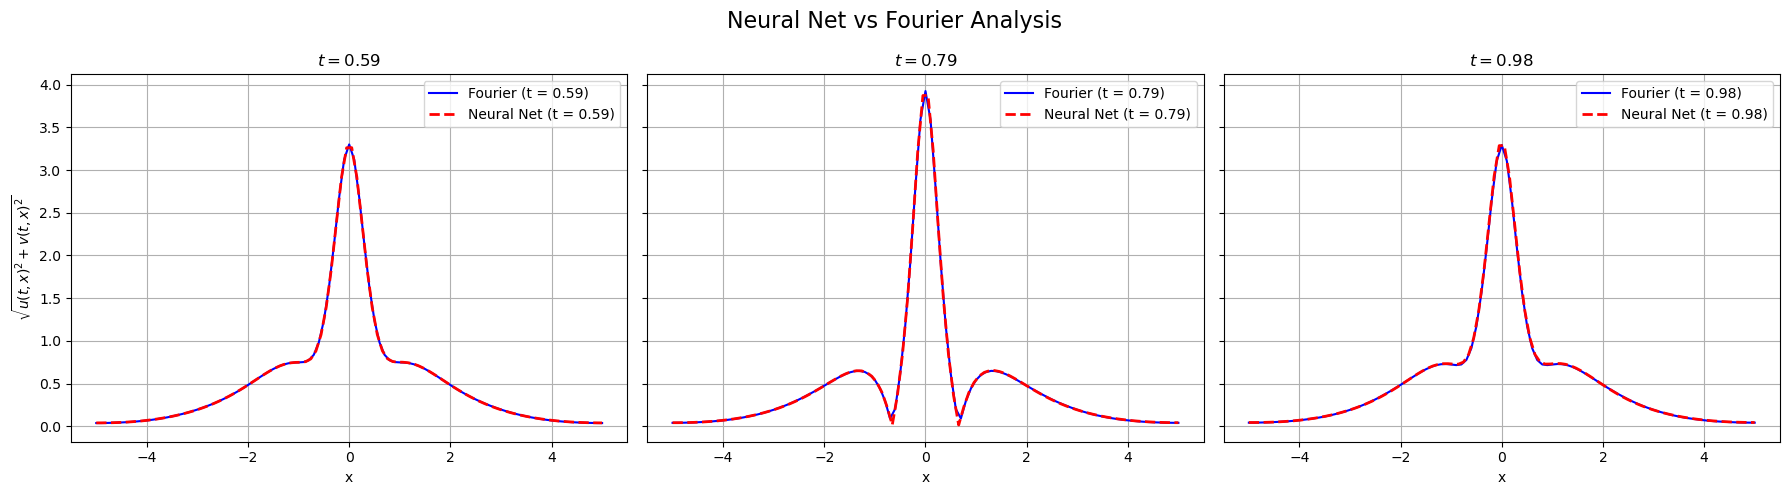

In [16]:
# -------------------------------
#  신경망 vs 푸리에 해석 비교 시각화
# -------------------------------
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (ax, t_nn) in enumerate(zip(axs, t_values.flatten().cpu().numpy())):
    #  푸리에 해석 결과 플롯 (먼저 그리기)
    nearest_idx = np.argmin(np.abs(t - t_nn))  # 가장 가까운 시간 인덱스 찾기
    ax.plot(x, np.abs(Z[:, nearest_idx]), label=f"Fourier (t = {t_nn:.2f})", color='b', linestyle='-')

    #  신경망 예측 결과 플롯 
    ax.plot(x_values.cpu().numpy(), combined[i], label=f"Neural Net (t = {t_nn:.2f})",
            color='r', linestyle='--', linewidth=2, zorder=3) 

    ax.set_title(f"$t = {t_nn:.2f}$")
    ax.set_xlabel("x")
    ax.grid()
    ax.legend()

axs[0].set_ylabel(r"$\sqrt{u(t, x)^2 + v(t, x)^2}$")
fig.suptitle(r"Neural Net vs Fourier Analysis", fontsize=16)
plt.tight_layout()
plt.show()
